In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib


In [3]:
#Load data
df = pd.read_csv('/home/martinmuti/Downloads/df1_loan.csv')
df

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,LP002586,Female,Yes,1,Graduate,No,3326,913.0,105.0,84.0,1.0,Semiurban,Y,$4239.0
496,496,LP002587,Male,Yes,0,Not Graduate,No,2600,1700.0,107.0,360.0,1.0,Rural,Y,$4300.0
497,497,LP002588,Male,Yes,0,Graduate,No,4625,2857.0,111.0,12.0,NaN,Urban,Y,$7482.0
498,498,LP002600,Male,Yes,1,Graduate,Yes,2895,0.0,95.0,360.0,1.0,Semiurban,Y,$2895.0


In [4]:
# Data cleaning and preprocessing
def preprocess_data(df):
    # Remove $ sign from Total_Income and convert to float
    df['Total_Income'] = df['Total_Income'].str.replace('$', '').astype(float)
    
    # Drop Loan_ID column
    df = df.drop('Loan_ID', axis=1)
    
    # Handle Dependents column
    df['Dependents'] = df['Dependents'].replace('3+', '3')
    df['Dependents'] = pd.to_numeric(df['Dependents'])
    
    # Convert categorical columns to category dtype
    categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
    for col in categorical_columns:
        df[col] = df[col].astype('category')
    
    # Convert numeric columns to float
    numeric_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Encode the target variable
    df['Loan_Status'] = df['Loan_Status'].map({'N': 0, 'Y': 1})
    
    # Remove rows with missing values
    df = df.dropna()
    
    return df

df = preprocess_data(df)

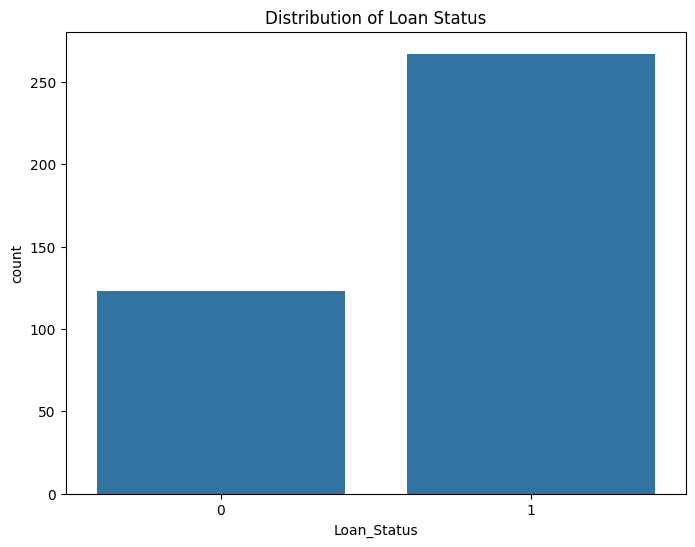

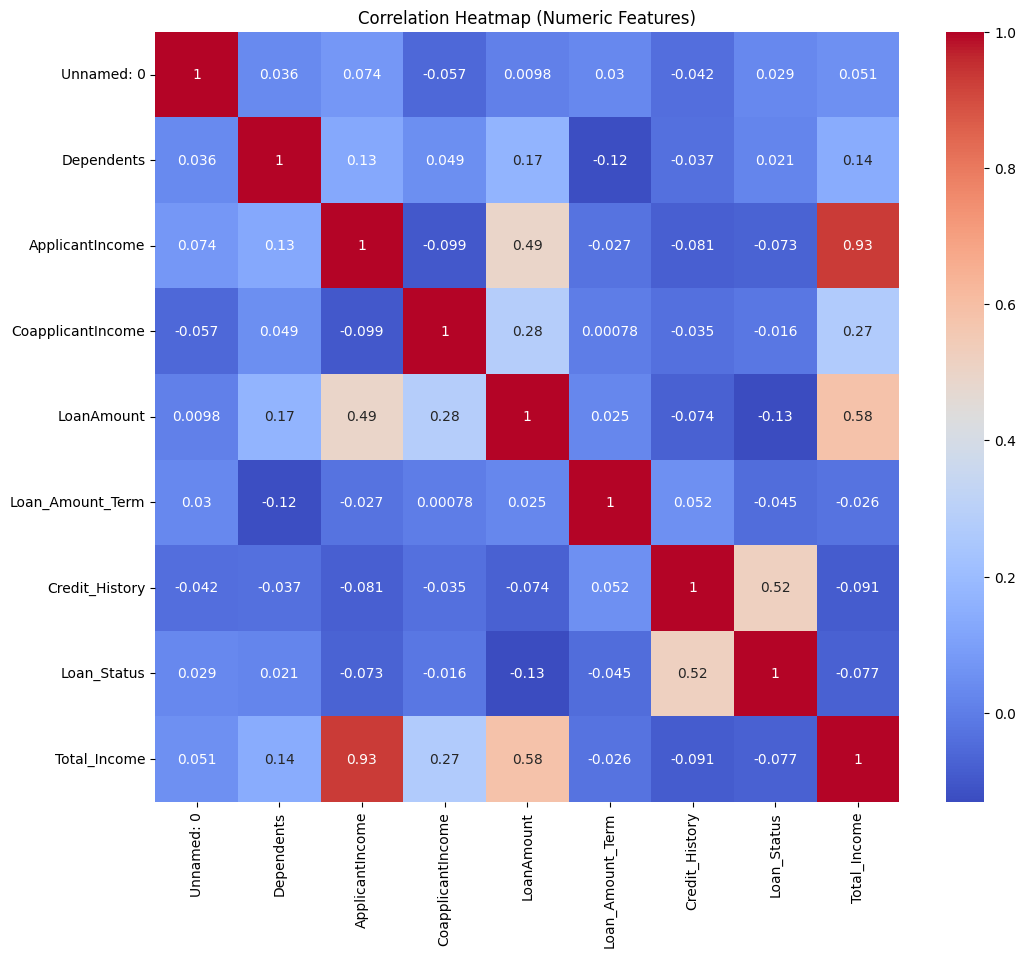

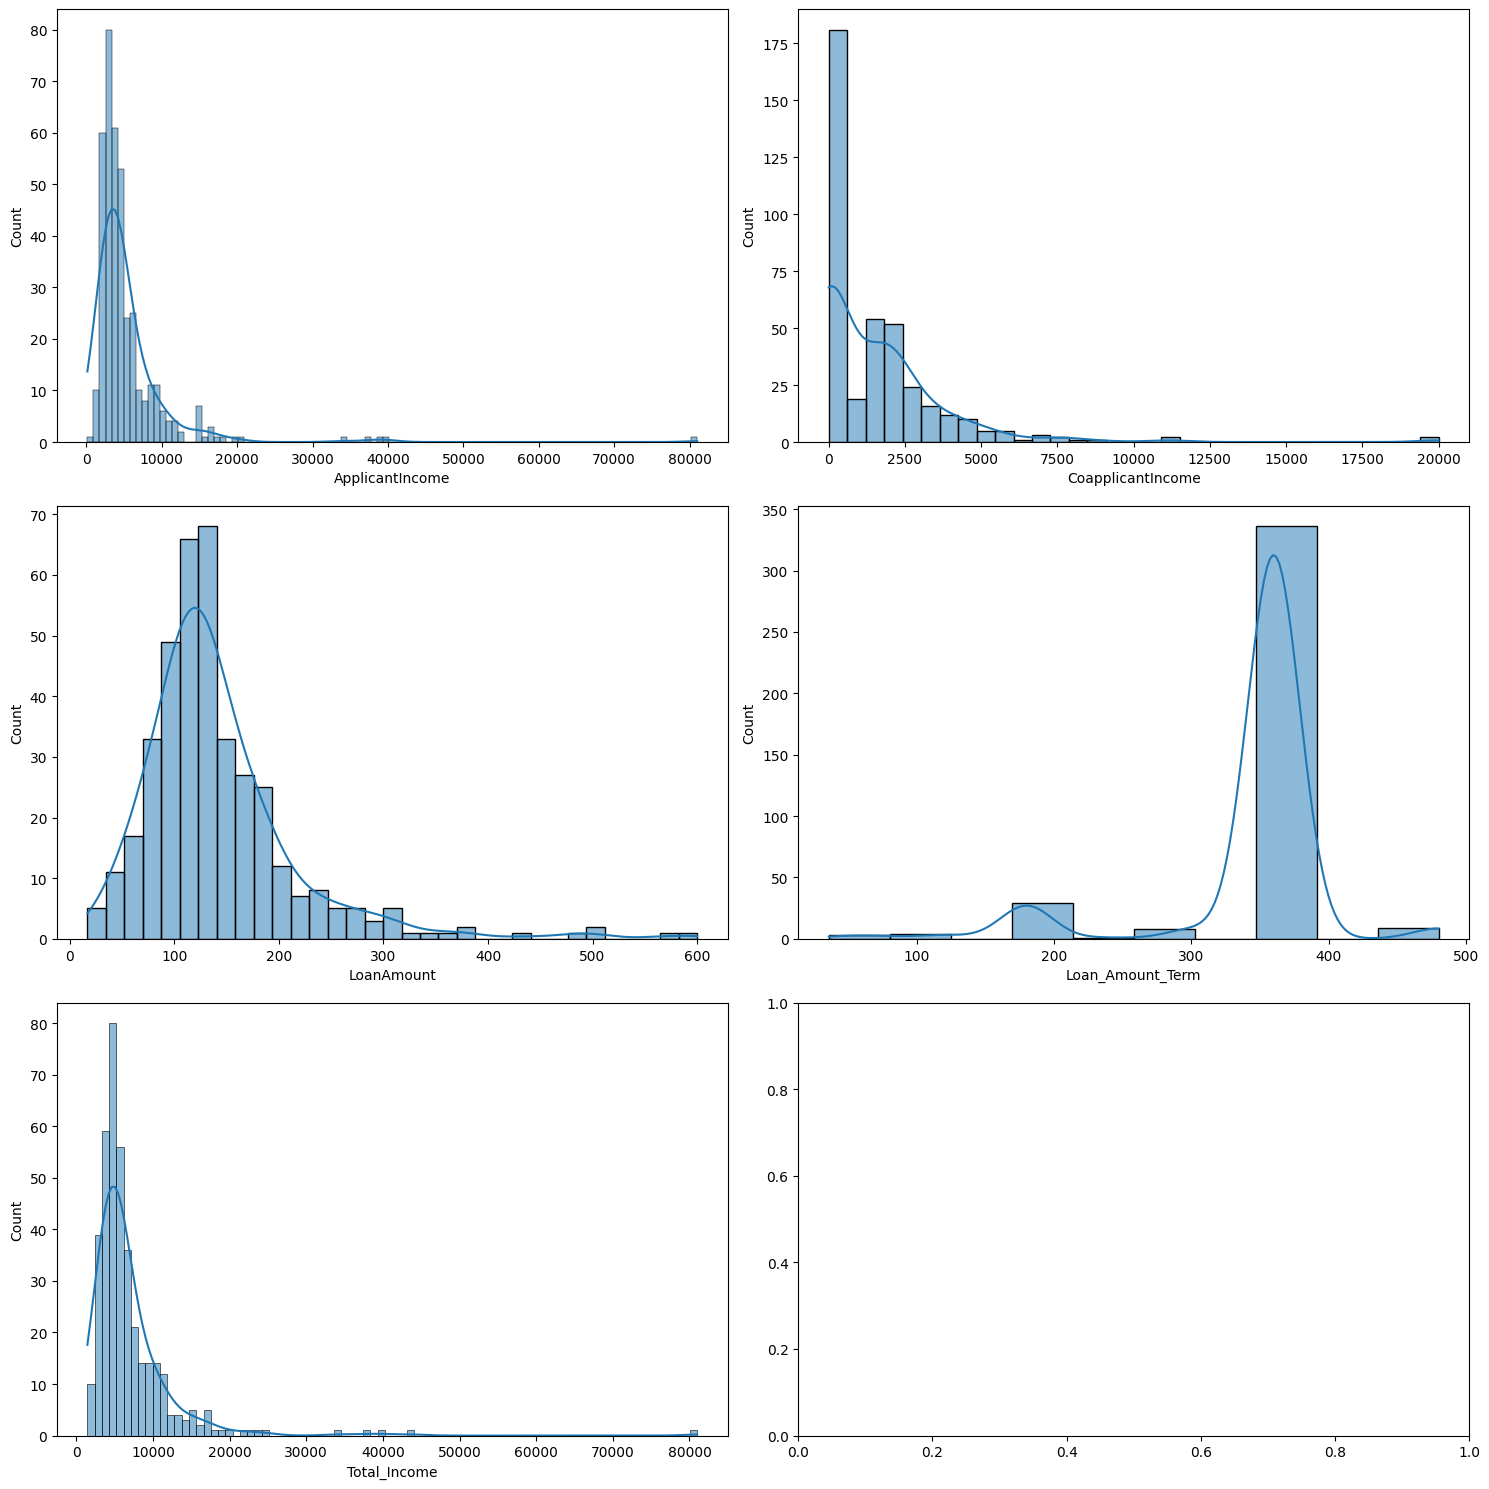

/tmp/ipykernel_3840270/1861969183.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45)
/tmp/ipykernel_3840270/1861969183.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45)
/tmp/ipykernel_3840270/1861969183.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45)
/tmp/ipykernel_3840270/1861969183.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=

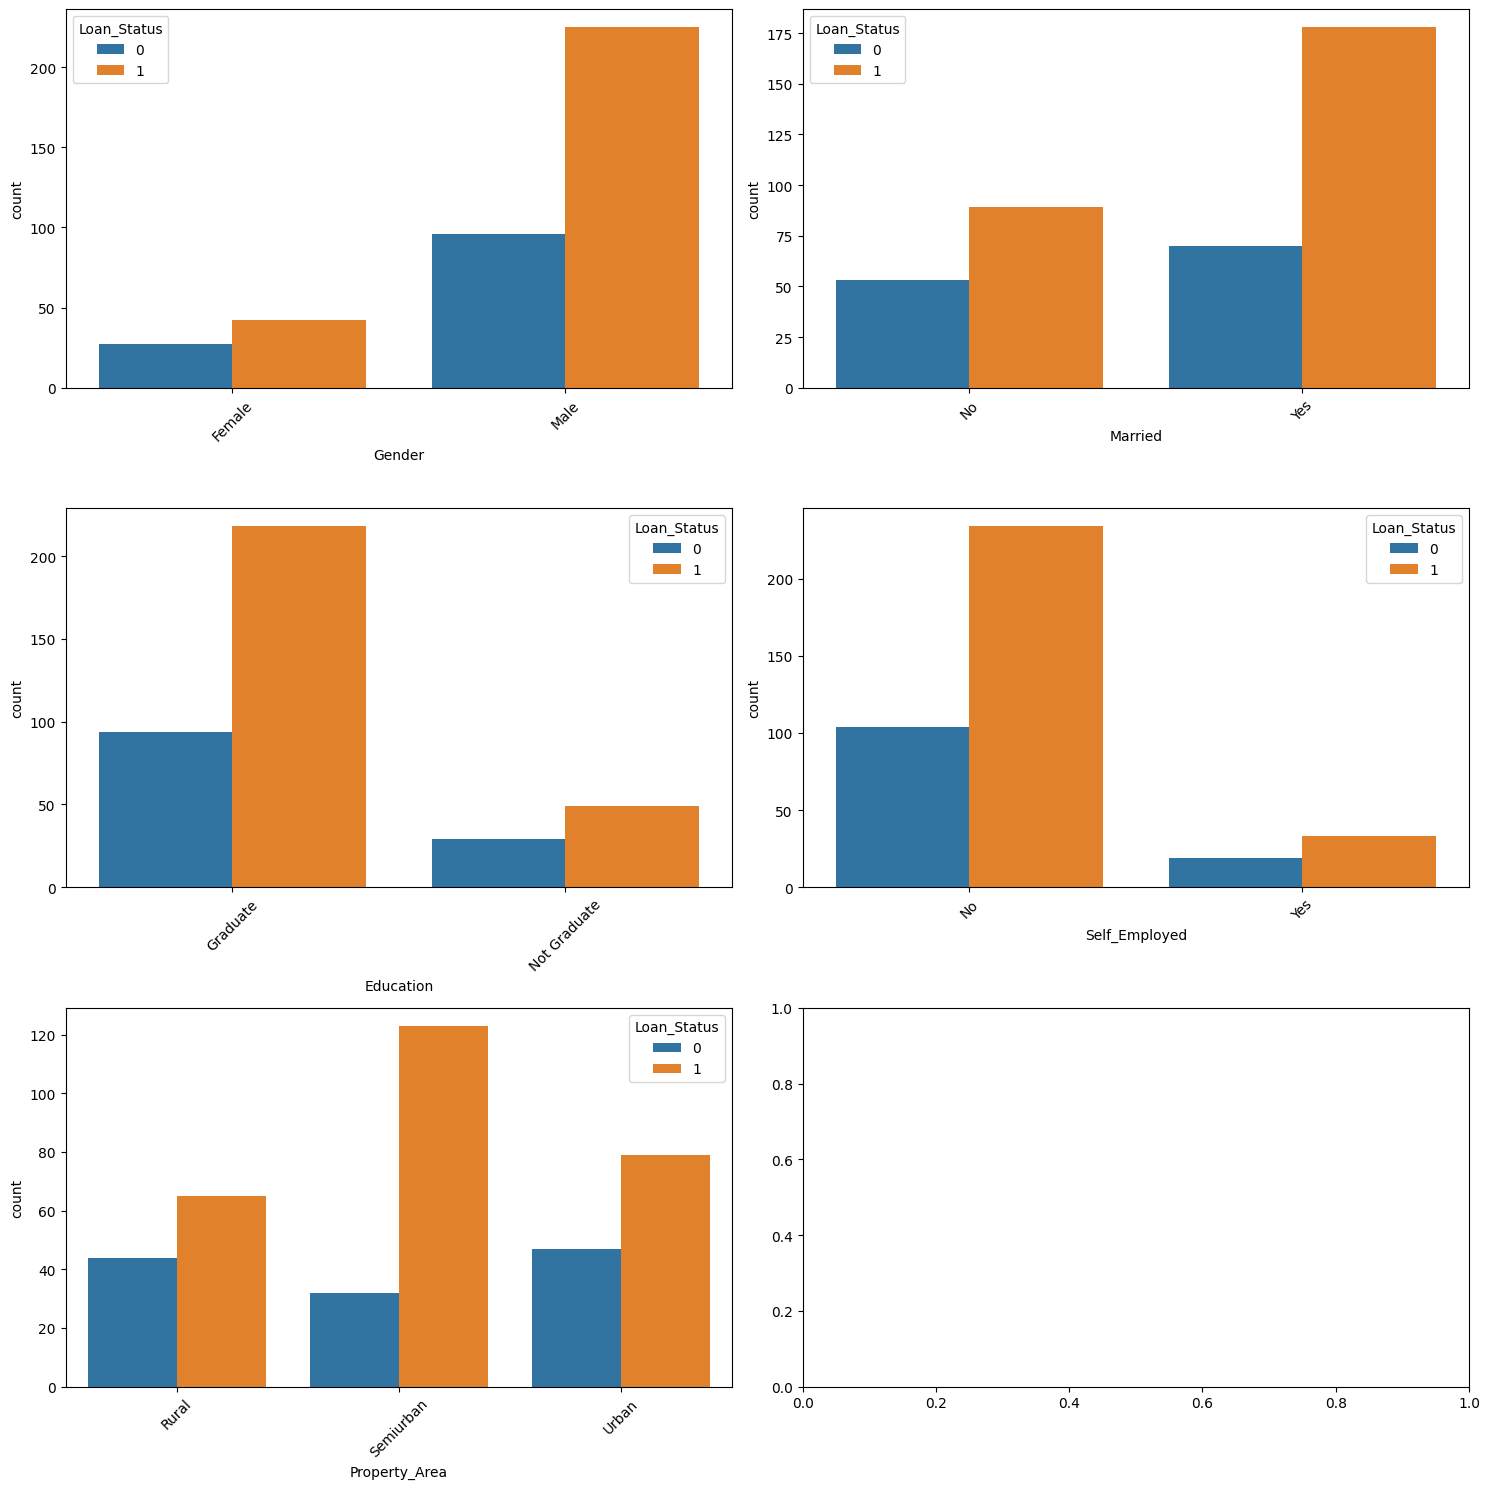

       Unnamed: 0  Dependents  ApplicantIncome  CoapplicantIncome  LoanAmount  \
count  390.000000  390.000000       390.000000         390.000000  390.000000   
mean   249.684615    0.738462      5420.438462        1537.261333  142.289744   
std    144.275160    1.008095      6025.716584        2268.942117   75.929142   
min      1.000000    0.000000       150.000000           0.000000   17.000000   
25%    132.250000    0.000000      2883.750000           0.000000  100.000000   
50%    249.500000    0.000000      3901.000000        1062.000000  127.500000   
75%    375.750000    1.000000      5827.000000        2250.000000  164.750000   
max    499.000000    3.000000     81000.000000       20000.000000  600.000000   

       Loan_Amount_Term  Credit_History  Loan_Status  Total_Income  
count        390.000000      390.000000   390.000000    390.000000  
mean         342.923077        0.851282     0.684615   6957.699795  
std           62.768594        0.356267     0.465266   6224.663

In [5]:
def perform_eda(df):
    # Distribution of target variable
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Loan_Status', data=df)
    plt.title('Distribution of Loan Status')
    plt.show()
    
    # Correlation heatmap for numeric columns only
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap (Numeric Features)')
    plt.show()
    
    # Distribution of numerical features
    numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income']
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for i, feature in enumerate(numerical_features):
        sns.histplot(df[feature], kde=True, ax=axes[i//2, i%2])
    plt.tight_layout()
    plt.show()
    
    # Categorical features vs Loan Status
    categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for i, feature in enumerate(categorical_features):
        sns.countplot(x=feature, hue='Loan_Status', data=df, ax=axes[i//2, i%2])
        axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(df.describe())
    
    # Print info about the dataset
    print(df.info())

perform_eda(df)

In [8]:
# Prepare data for modeling
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Total_Income', 'Dependents']
categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [9]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def train_evaluate_models(models, X_train, X_test, y_train, y_test, le):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)])
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Convert class labels to strings
        target_names = [str(class_) for class_ in le.classes_]
        
        # Store results
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, target_names=target_names),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'pipeline': pipeline
        }
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Accuracy: {results[name]['accuracy']:.4f}")
        print("\nClassification Report:")
        print(results[name]['classification_report'])
        print("\nConfusion Matrix:")
        print(results[name]['confusion_matrix'])
        
        # Cross-validation
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
        print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return results

results = train_evaluate_models(models, X_train, X_test, y_train, y_test, le)

# Hyperparameter tuning for the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]

if best_model_name == 'Random Forest':
    param_dist = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'XGBoost':
    param_dist = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 4, 5],
        'classifier__learning_rate': [0.01, 0.1, 0.3],
        'classifier__subsample': [0.6, 0.8, 1.0]
    }
else:  # Logistic Regression
    param_dist = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'newton-cg', 'sag']
    }

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', best_model)])

random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X, y)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Feature importance (for Random Forest or XGBoost)
if best_model_name in ['Random Forest', 'XGBoost']:
    feature_names = (numeric_features + 
                     [f"{feature}_{category}" for feature, categories in 
                      random_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].categories_ 
                      for category in categories[1:]])
    
    importances = random_search.best_estimator_.named_steps['classifier'].feature_importances_
    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    feature_importances.head(10).plot(kind='bar')
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()

    # Final model evaluation
final_model = random_search.best_estimator_
y_pred = final_model.predict(X_test)

# Convert class labels to strings
target_names = [str(class_) for class_ in le.classes_]

print("\nFinal Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# After training your model and preprocessor
model_data = {
    'model': final_model,
    'preprocessor': preprocessor
}
joblib.dump(model_data, 'loan_predictor_model.joblib')


Logistic Regression Results:
Accuracy: 0.7821

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.46      0.60        28
           1       0.76      0.96      0.85        50

    accuracy                           0.78        78
   macro avg       0.81      0.71      0.73        78
weighted avg       0.80      0.78      0.76        78


Confusion Matrix:
[[13 15]
 [ 2 48]]

Cross-Validation Accuracy: 0.8051 (+/- 0.0676)

Random Forest Results:
Accuracy: 0.7436

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.46      0.57        28
           1       0.75      0.90      0.82        50

    accuracy                           0.74        78
   macro avg       0.74      0.68      0.69        78
weighted avg       0.74      0.74      0.73        78


Confusion Matrix:
[[13 15]
 [ 5 45]]

Cross-Validation Accuracy: 0.7897 (+/- 0.0261)


/home/martinmuti/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:42:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Accuracy: 0.7051

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.43      0.51        28
           1       0.73      0.86      0.79        50

    accuracy                           0.71        78
   macro avg       0.68      0.64      0.65        78
weighted avg       0.69      0.71      0.69        78


Confusion Matrix:
[[12 16]
 [ 7 43]]


/home/martinmuti/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/martinmuti/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/martinmuti/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/martinmuti/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/martinmuti/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:42:05] WA


Cross-Validation Accuracy: 0.7385 (+/- 0.0940)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.1s


/home/martinmuti/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.1s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=sag; total time=   0.1s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=sag; total time=   0.2s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=sag; total time=   0.1s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=sag; total time=   0.1

/home/martinmuti/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martinmuti/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=sag; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.1s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=sag; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=newton-cg; total time=   0.1s
[CV] END classifi

/home/martinmuti/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martinmuti/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters found: {'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 0.1}
Best cross-validation score: 0.8076923076923077

Final Model Evaluation:
Accuracy: 0.7949

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.46      0.62        28
           1       0.77      0.98      0.86        50

    accuracy                           0.79        78
   macro avg       0.85      0.72      0.74        78
weighted avg       0.82      0.79      0.77        78


Confusion Matrix:
[[13 15]
 [ 1 49]]
Model saved as 'loan_predictor_model.joblib'
